Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


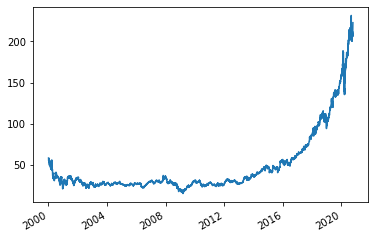

In [3]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import scipy.stats as stat

import datetime
import numpy as np


from yahoo_fin.stock_info import *

# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2000,1,1)
end = datetime.date.today()




stock = get_data('msft' , start_date = start, end_date = end)

stock.head()

stock["close"].plot(grid = False) # Plot the adjusted closing price 
close = pd.DataFrame(stock["close"])

Populating the interactive namespace from numpy and matplotlib


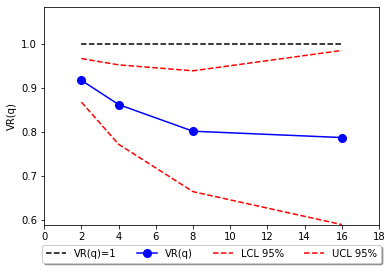

In [6]:

vrt = []
w=[]
varvrt = []
zvrt = []
q = []
lcl=[]
ucl=[]
vr_1=[]
p_value=[]
alpha=0.05

def VRTest(x,k,alpha):
    
    x = np.asarray(x)
    x = np.log(x)
    n = len(x)-1

    # Estimate the mean
    mu = (x[-1]-x[0])/n
  
    # Estimate the variance for the 1st order difference

    sig_1 = sum((x[1:n]-x[0:n-1]-mu)**2)/(n)
  
    for ii in range (1, k+1):
        a=2**ii
        q.append(a)
    for i in range(len(q)):
        m=(n-q[i]+1)*(1-q[i]/n)
       # Estimate the variance for the q-th order difference
        sig_q=sum((x[1+q[i]:n]-x[1:n-q[i]]-q[i]*mu)**2)/(m*q[i])
       # The raw value of the VRT
        vr=sig_q/(sig_1)

        vv=0
        for j in range (1,q[i]):
             
            sum2=sum((x[2:n-j]-x[1:n-j-1]-mu)**2)
             
            sum1=sum(((x[j+2:n]-x[j+1:n-1]-mu)**2)*(((x[2:n-j]-x[1:n-j-1]-mu)**2)))
                
            delta=sum1/(sum2**2)
            vv=vv+(((2*(q[i]-j)/q[i])**2)*delta)
        v=vv
        z=(vr-1)/np.sqrt(v)
        one=1
        lower=vr-stat.norm.ppf(1-alpha/2)*np.sqrt(v)
        upper=vr+stat.norm.ppf(1-alpha/2)*np.sqrt(v)
        pval=stat.norm.cdf(z)
        varvrt.append(v)
        zvrt.append(z)
        vrt.append(vr)
        lcl.append(lower)
        ucl.append(upper)
        vr_1.append(one)
        p_value.append(pval)
        
    return vrt,p_value,zvrt,q;
k=4
VRTest(close,k,alpha)
confidence=1-alpha
%pylab inline
#pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
plt.ylim(min(lcl), max(ucl)*1.1)
plt.xlim(0, 2**k+2)
plt.xlabel( 'q' )
plt.ylabel( 'VR(q)' )
plt.plot(q, vr_1,color='black', linestyle='dashed', label='VR(q)=1')
plt.plot(q, vrt, color='blue', marker='o',markerfacecolor='blue', markersize=8,label='VR(q)')
plt.plot(q, lcl,color='red', linestyle='dashed', label='LCL ' +str('{:.0%}'.format(confidence)))
plt.plot(q, ucl,color='red', linestyle='dashed', label='UCL ' +str('{:.0%}'.format(confidence)))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),fancybox=True, shadow=True, ncol=5)

plt.show()

# Individual Variance Ratio Test

In [7]:

results=pd.DataFrame(columns=['q','VR test', 'z statistic', 'P-value'])
results['q']=q
results['VR test']=vrt
results['z statistic']=zvrt
results['P-value']=p_value

In [116]:
%%latex
\[\left\{ \begin{align}
  & {{H}_{0i}}:VR({{q}_{i}})=1 \\ 
 & {{H}_{Ai}}:VR({{q}_{i}})\ne 1 \\ 
\end{align} \right.\]


<IPython.core.display.Latex object>

In [8]:
results

,q,VR test,z statistic,P-value
0,2,[0.9165649987791218],[-3.3093517376128028],[0.00046756138966626694]
1,4,[0.8615353080845876],[-3.0104989110488733],[0.0013040944161031398]
2,8,[0.8009819750680817],[-2.842069444818066],[0.0022410863579295013]
3,16,[0.786641677666045],[-2.115131910243346],[0.01720935309808621]


# Multiple Variance Ratio Test

In [9]:

z=abs(results["z statistic"]).max()
p_v=stat.norm.cdf(stat.norm.ppf(1-(1-alpha)**(1/len(results))))
mvr=pd.DataFrame(columns=['z statistic', 'P-value'])
mvr.at[0,"z statistic"]=z
mvr["P-value"]=p_v


In [10]:
mvr

,z statistic,P-value
0,[3.3093517376128028],0.012741
